In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =6.375563e-24

nband = 80

ng =9

ng_adju = (/ 0 , 0 /) 

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 1000

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.65 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

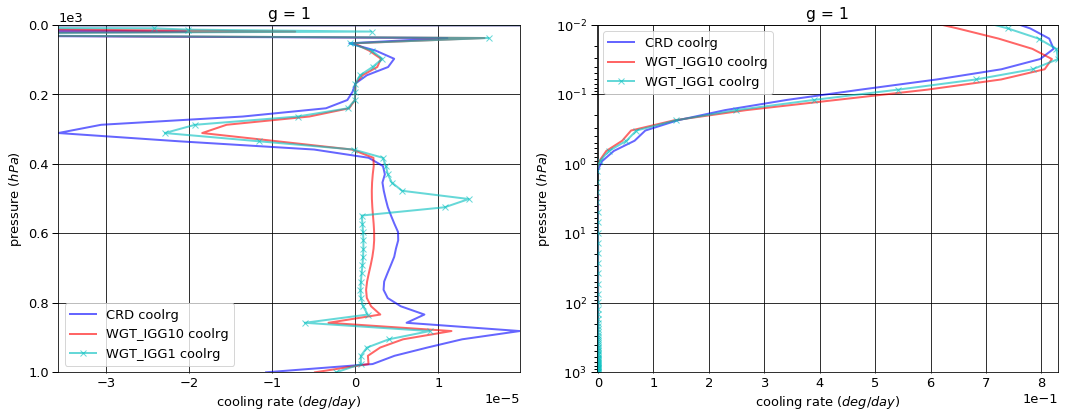

# Figure: cooling rate g-group 2

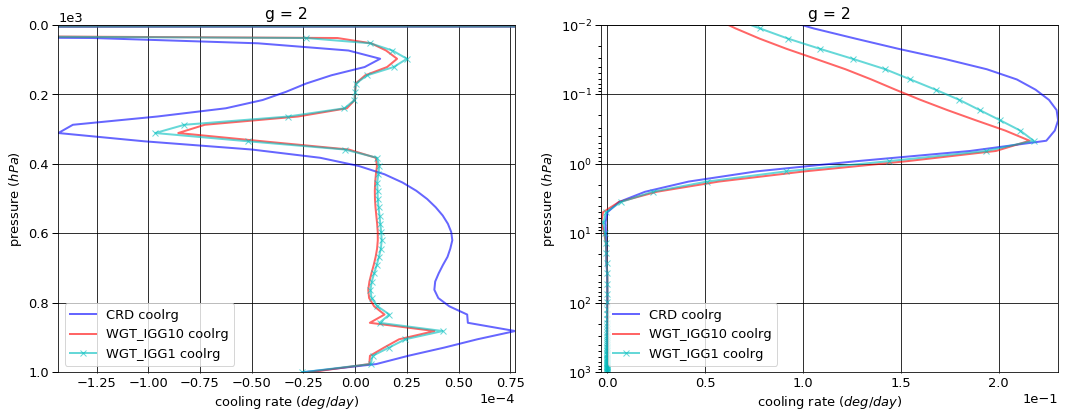

# Figure: cooling rate g-group 3

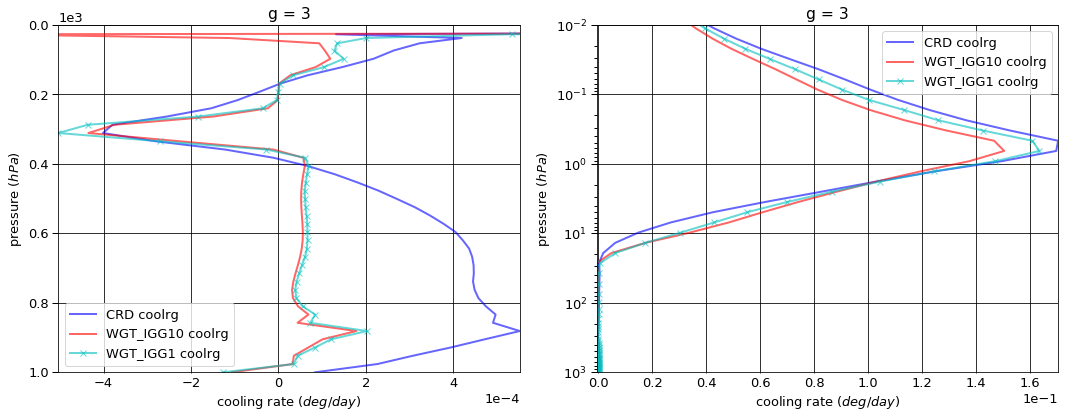

# Figure: cooling rate g-group 4

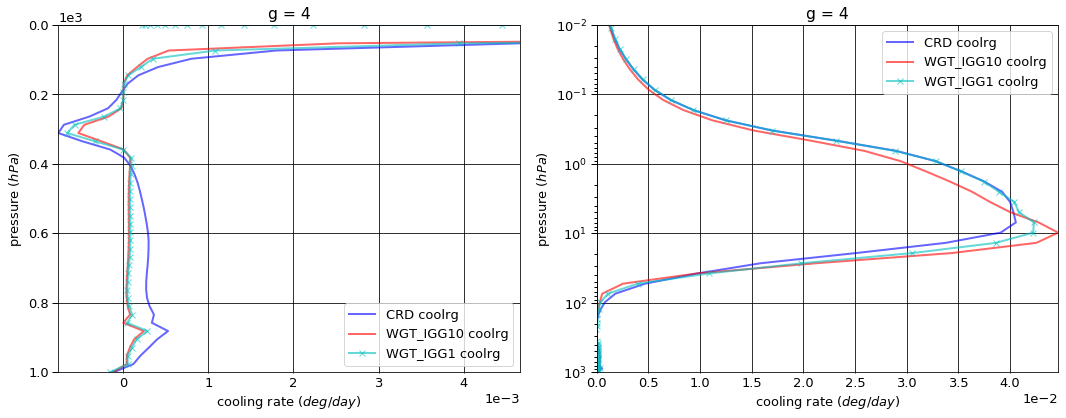

# Figure: cooling rate g-group 5

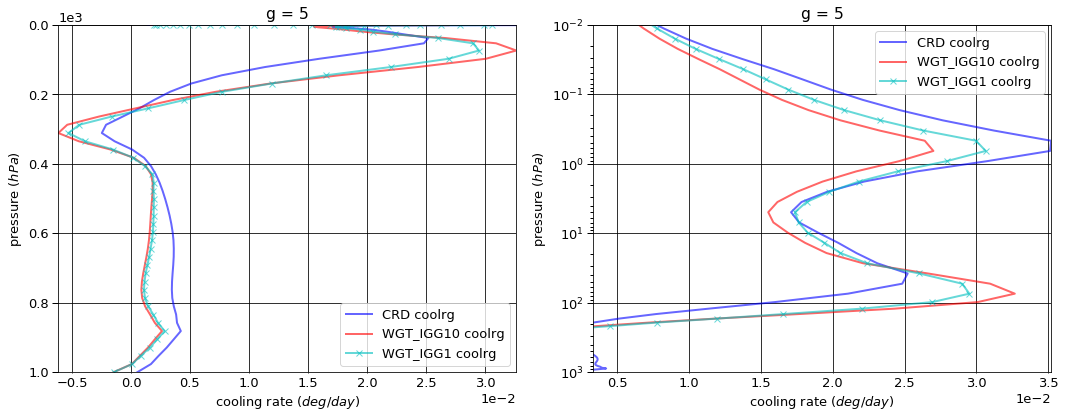

# Figure: cooling rate g-group 6

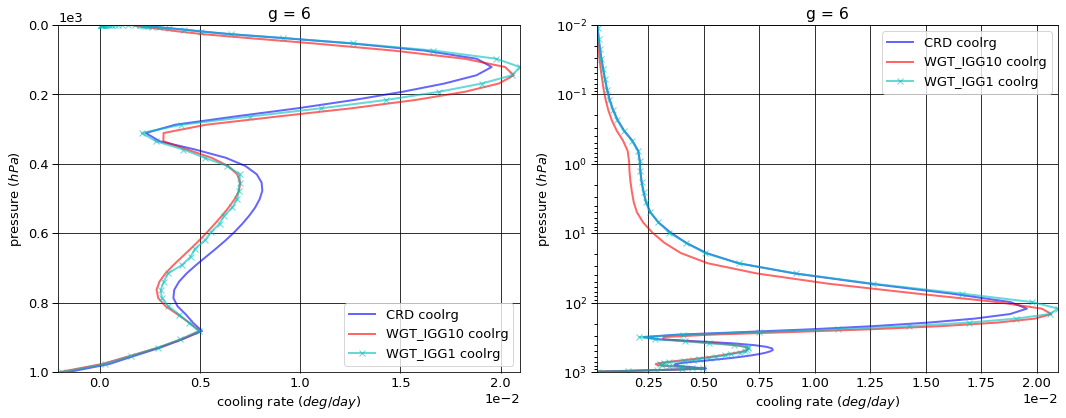

# Figure: cooling rate g-group 7

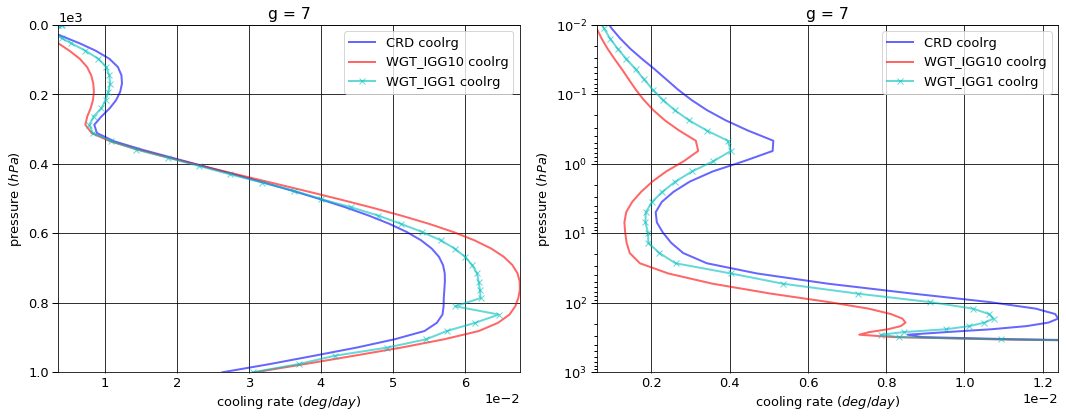

# Figure: cooling rate g-group 8

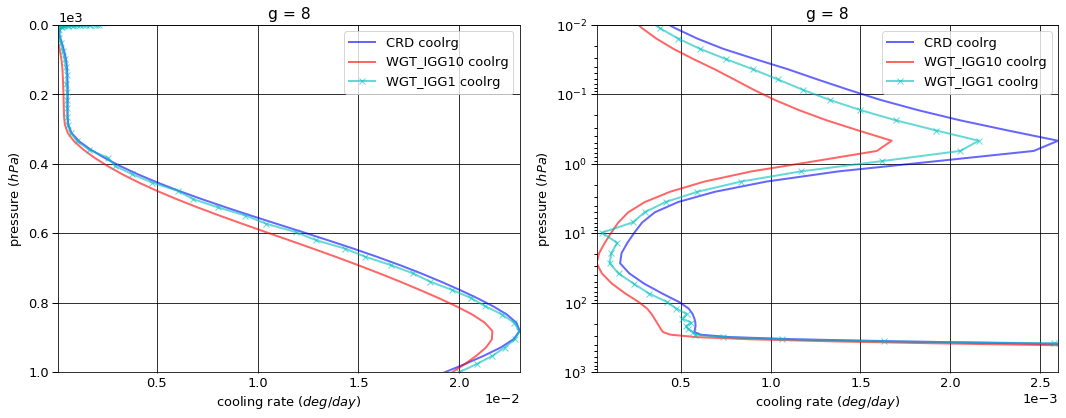

# Figure: cooling rate g-group 9

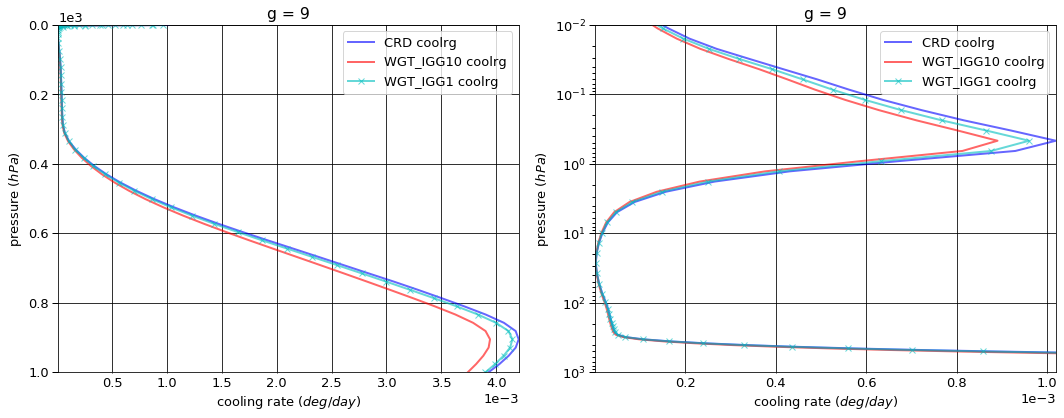

# Figure: cooling rate g-group total

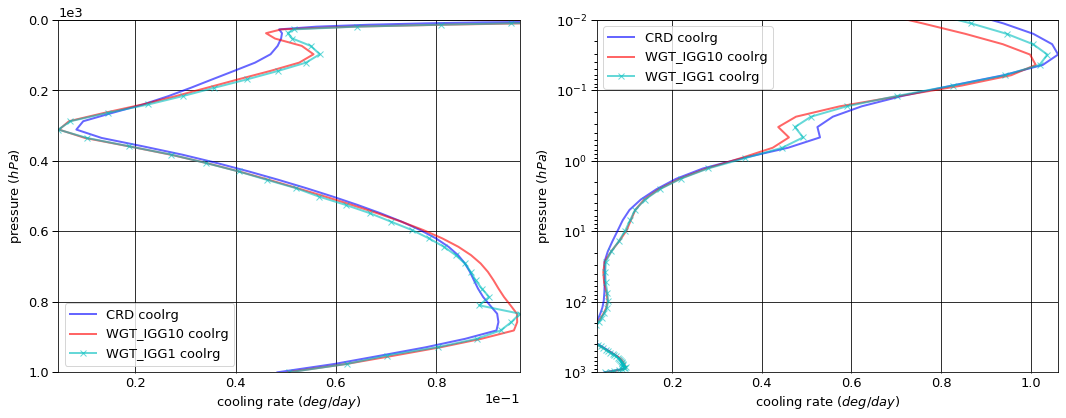

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014575  0.000000 -0.014575
  1013.0   76    -0.017009  0.017058  0.000049
2 0.0      1     -0.031770  0.000000 -0.031770
  1013.0   76    -0.037820  0.037961  0.000141
3 0.0      1     -0.109324  0.000000 -0.109324
  1013.0   76    -0.166003  0.157091 -0.008912
4 0.0      1     -0.151194  0.000000 -0.151194
  1013.0   76    -0.285671  0.284393 -0.001278
5 0.0      1     -0.660066  0.000000 -0.660066
  1013.0   76    -1.098661  1.008500 -0.090161
6 0.0      1     -0.850986  0.000000 -0.850986
  1013.0   76    -1.498911  1.512172  0.013262
7 0.0      1     -4.963375  0.000000 -4.963375
  1013.0   76    -6.243358  5.206276 -1.037082
8 0.0      1     -5.223356  0.000000 -5.223356
  1013.0   76    -5.396115  1.338047 -4.058068
9 0.0      1     -8.830282  0.000000 -8.830282
  1013.0   76    -8.847591  0.207468 -8.640123


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014576  0.000000 -0.014576
  1013.0   76    -0.017009  0.017026  0.000017
2 0.0      1     -0.032148  0.000000 -0.032148
  1013.0   76    -0.037820  0.037898  0.000078
3 0.0      1     -0.100890  0.000000 -0.100890
  1013.0   76    -0.166003  0.166383  0.000380
4 0.0      1     -0.147579  0.000000 -0.147579
  1013.0   76    -0.285671  0.286099  0.000428
5 0.0      1     -0.569770  0.000000 -0.569770
  1013.0   76    -1.098661  1.106490  0.007828
6 0.0      1     -0.821275  0.000000 -0.821275
  1013.0   76    -1.498911  1.514254  0.015344
7 0.0      1     -4.967655  0.000000 -4.967655
  1013.0   76    -6.243358  5.551671 -0.691686
8 0.0      1     -5.255556  0.000000 -5.255556
  1013.0   76    -5.396115  1.195420 -4.200695
9 0.0      1     -8.832089  0.000000 -8.832089
  1013.0   76    -8.847591  0.191998 -8.655593


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014522  0.000000 -0.014522
  1013.0   76    -0.017009  0.017017  0.000008
2 0.0      1     -0.031980  0.000000 -0.031980
  1013.0   76    -0.037820  0.037911  0.000091
3 0.0      1     -0.101150  0.000000 -0.101150
  1013.0   76    -0.166003  0.166466  0.000463
4 0.0      1     -0.148065  0.000000 -0.148065
  1013.0   76    -0.285671  0.286232  0.000562
5 0.0      1     -0.571859  0.000000 -0.571859
  1013.0   76    -1.098661  1.107410  0.008749
6 0.0      1     -0.826574  0.000000 -0.826574
  1013.0   76    -1.498911  1.513826  0.014916
7 0.0      1     -4.957252  0.000000 -4.957252
  1013.0   76    -6.243358  5.373262 -0.870096
8 0.0      1     -5.229903  0.000000 -5.229903
  1013.0   76    -5.396115  1.315097 -4.081018
9 0.0      1     -8.830955  0.000000 -8.830955
  1013.0   76    -8.847591  0.203307 -8.644285


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.070000e-06  0.000000 -0.000001
  1013.0   76     0.000000e+00 -0.000032 -0.000032
2 0.0      1     -3.784500e-04  0.000000 -0.000378
  1013.0   76     0.000000e+00 -0.000063 -0.000063
3 0.0      1      8.433560e-03  0.000000  0.008434
  1013.0   76     0.000000e+00  0.009292  0.009292
4 0.0      1      3.614470e-03  0.000000  0.003614
  1013.0   76     0.000000e+00  0.001706  0.001706
5 0.0      1      9.029691e-02  0.000000  0.090297
  1013.0   76     0.000000e+00  0.097990  0.097990
6 0.0      1      2.971058e-02  0.000000  0.029711
  1013.0   76     0.000000e+00  0.002082  0.002082
7 0.0      1     -4.279700e-03  0.000000 -0.004280
  1013.0   76    -8.881784e-16  0.345395  0.345396
8 0.0      1     -3.220010e-02  0.000000 -0.032200
  1013.0   76     0.000000e+00 -0.142627 -0.142627
9 0.0      1     -1.807200e-03  0.000000 -0.001807
  1013.0   76     0.000000e+00 -0.015469 -0.015469


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.257200e-05  0.000000  0.000053
  1013.0   76     0.000000e+00 -0.000041 -0.000041
2 0.0      1     -2.099540e-04  0.000000 -0.000210
  1013.0   76     0.000000e+00 -0.000050 -0.000050
3 0.0      1      8.173780e-03  0.000000  0.008174
  1013.0   76     0.000000e+00  0.009375  0.009375
4 0.0      1      3.129150e-03  0.000000  0.003129
  1013.0   76     0.000000e+00  0.001839  0.001839
5 0.0      1      8.820708e-02  0.000000  0.088207
  1013.0   76     0.000000e+00  0.098910  0.098910
6 0.0      1      2.441164e-02  0.000000  0.024412
  1013.0   76     0.000000e+00  0.001654  0.001654
7 0.0      1      6.123900e-03  0.000000  0.006124
  1013.0   76    -8.881784e-16  0.166986  0.166986
8 0.0      1     -6.547200e-03  0.000000 -0.006547
  1013.0   76     0.000000e+00 -0.022950 -0.022950
9 0.0      1     -6.737000e-04  0.000000 -0.000674
  1013.0   76     0.000000e+00 -0.004161 -0.004161

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.177910
  1001.112500 75    -0.000011
2 0.000312    1      0.005214
  1001.112500 75    -0.000025
3 0.000312    1      0.006610
  1001.112500 75     0.000084
4 0.000312    1      0.000198
  1001.112500 75    -0.000117
5 0.000312    1      0.001436
  1001.112500 75     0.000528
6 0.000312    1      0.000032
  1001.112500 75    -0.001633
7 0.000312    1      0.000131
  1001.112500 75     0.026318
8 0.000312    1      0.000018
  1001.112500 75     0.019279
9 0.000312    1      0.000001
  1001.112500 75     0.003930


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      6.964005e-02
  1001.112500 75    -4.835666e-06
2 0.000312    1      5.888646e-03
  1001.112500 75    -2.216037e-05
3 0.000312    1      7.711975e-03
  1001.112500 75    -1.067067e-04
4 0.000312    1      2.093742e-04
  1001.112500 75    -1.228501e-04
5 0.000312    1      1.701527e-03
  1001.112500 75    -1.495796e-03
6 0.000312    1      3.229531e-05
  1001.112500 75    -2.076409e-03
7 0.000312    1      6.620777e-05
  1001.112500 75     3.085971e-02
8 0.000312    1      1.526236e-08
  1001.112500 75     1.965049e-02
9 0.000312    1     -3.874070e-07
  1001.112500 75     3.740920e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.233633e-01
  1001.112500 75    -2.280414e-06
2 0.000312    1      5.631392e-03
  1001.112500 75    -2.558961e-05
3 0.000312    1      7.615200e-03
  1001.112500 75    -1.267823e-04
4 0.000312    1      2.240685e-04
  1001.112500 75    -1.600583e-04
5 0.000312    1      1.925797e-03
  1001.112500 75    -1.463612e-03
6 0.000312    1      4.255693e-05
  1001.112500 75    -1.910587e-03
7 0.000312    1      1.088729e-04
  1001.112500 75     3.053392e-02
8 0.000312    1      1.153354e-05
  1001.112500 75     1.999257e-02
9 0.000312    1     -1.655684e-07
  1001.112500 75     3.902104e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.082699e-01
  1001.112500 75     5.887481e-06
2 0.000312    1      6.747274e-04
  1001.112500 75     3.259064e-06
3 0.000312    1      1.102042e-03
  1001.112500 75    -1.906242e-04
4 0.000312    1      1.111023e-05
  1001.112500 75    -5.845290e-06
5 0.000312    1      2.654280e-04
  1001.112500 75    -2.023785e-03
6 0.000312    1     -3.739500e-08
  1001.112500 75    -4.438366e-04
7 0.000312    1     -6.497294e-05
  1001.112500 75     4.542029e-03
8 0.000312    1     -1.752906e-05
  1001.112500 75     3.713040e-04
9 0.000312    1     -1.653715e-06
  1001.112500 75    -1.886961e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.454657e-02
  1001.112500 75     8.442732e-06
2 0.000312    1      4.174733e-04
  1001.112500 75    -1.701710e-07
3 0.000312    1      1.005267e-03
  1001.112500 75    -2.106997e-04
4 0.000312    1      2.580455e-05
  1001.112500 75    -4.305349e-05
5 0.000312    1      4.896988e-04
  1001.112500 75    -1.991601e-03
6 0.000312    1      1.022422e-05
  1001.112500 75    -2.780144e-04
7 0.000312    1     -2.230777e-05
  1001.112500 75     4.216241e-03
8 0.000312    1     -6.010777e-06
  1001.112500 75     7.133900e-04
9 0.000312    1     -1.431876e-06
  1001.112500 75    -2.751260e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.834928,0.000000,-20.834928
1013.0,76,-23.591138,9.768966,-13.822172



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.741539,0.00000,-20.741539
1013.0,76,-23.591138,10.06724,-13.523898



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.712260,0.000000,-20.71226
1013.0,76,-23.591138,10.020528,-13.57061



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.093389,0.000000,0.093389
1013.0,76,0.000000,0.298274,0.298274



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.122667,0.000000,0.122667
1013.0,76,0.000000,0.251562,0.251562


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.191550
1001.112500,75,0.048353



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.085250
1001.112500,75,0.050422



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.138923
1001.112500,75,0.050740



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.106301
1001.112500,75,0.002070



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.052628
1001.112500,75,0.002387


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000737,0.000718
2,0.001638,0.001596
3,0.007162,0.007011
4,0.012375,0.012056
5,0.047313,0.046418
6,0.064750,0.063288
7,0.268363,0.263841
8,0.227887,0.228856
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.344054e-19
2,2.155925e-20
3,1.982895e-21
4,1.784805e-21
5,1.648433e-22
6,7.248533e-22
7,6.798069e-23
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.344054e-19,NaN,0.000737,0.000718,0.000737,0.000718,1.0
2,2.155925e-20,0.091974,0.001638,0.001596,0.002375,0.002314,1.0
3,1.982895e-21,0.091974,0.007162,0.007011,0.009537,0.009325,1.0
4,1.784805e-21,0.900100,0.012375,0.012056,0.021913,0.021381,10.0
5,1.648433e-22,0.092359,0.047313,0.046418,0.069225,0.067799,10.0
6,7.248533e-22,4.397225,0.064750,0.063288,0.133975,0.131087,500.0
7,6.798069e-23,0.093785,0.268363,0.263841,0.402338,0.394928,500.0
8,6.375599e-24,0.093785,0.227887,0.228856,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
